In [1]:
import numpy as np
import matplotlib.pyplot as plot
import dsp

### Generate Noise

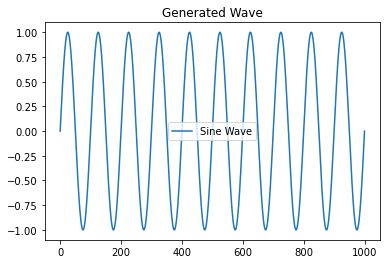

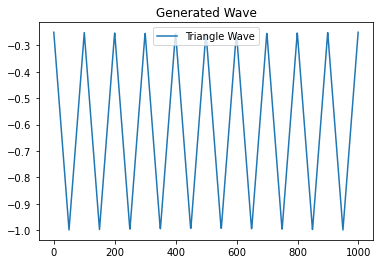

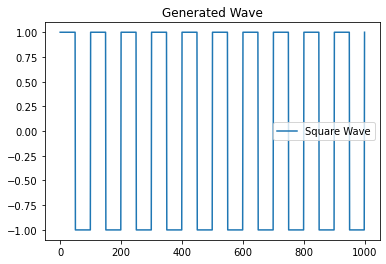

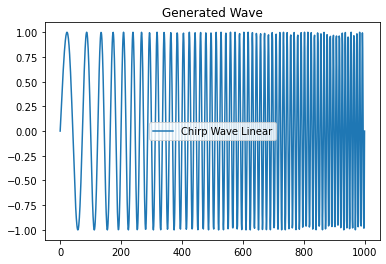

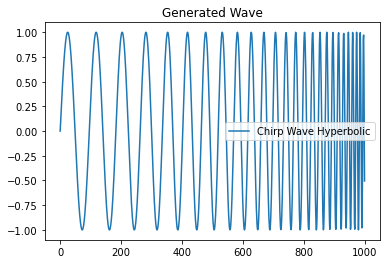

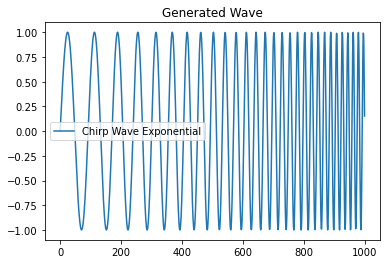

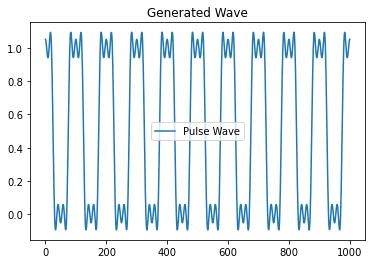

In [2]:
from dsp import sine_wave, triangle_wave, square_wave, chirp_wave_linear, chirp_wave_hyperbolic, chirp_wave_exponential, pulse_wave

sie_ = sine_wave(show=True)
triangle_ = triangle_wave(show=True)
square_ = square_wave(show=True)
chirp_linear_ = chirp_wave_linear(show=True)
chirp_hyperbolic = chirp_wave_hyperbolic(show=True)
chirp_exponential = chirp_wave_exponential(show=True)
pulse_ = pulse_wave(show=True)

### Add Noise

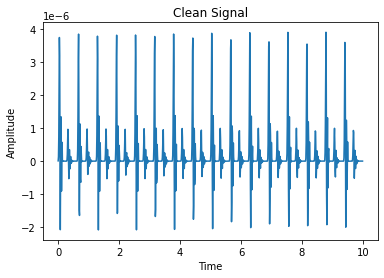

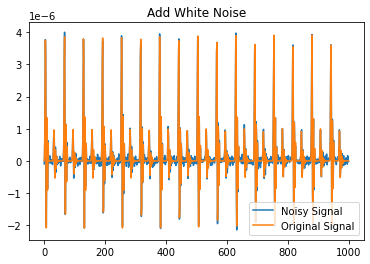

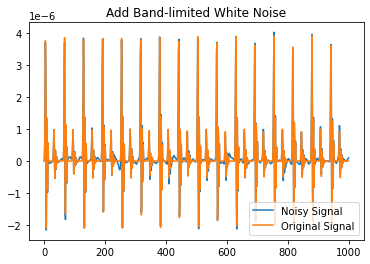

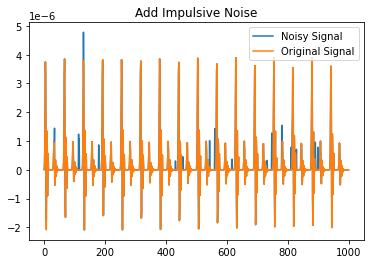

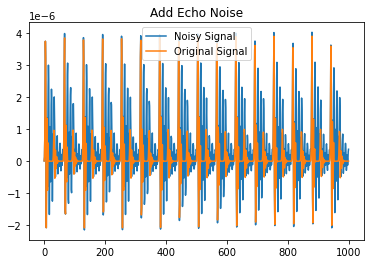

In [4]:
from dsp import add_white_noise, add_band_limited_white_noise, add_impulsive_noise, add_echo_noise
from Dataset import load_scg
import matplotlib.pyplot as plt

signals_clean, labels_clean, duration, fs = load_scg(0, 'train')
signal = signals_clean[0]
sampling_rate = fs

time = np.linspace(0, duration, sampling_rate * duration, endpoint=False)

plt.plot(time, signal)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Clean Signal')

signal_with_white_noise = add_white_noise(signal, show=True)
signal_with_band_limited_white_noise = add_band_limited_white_noise(signal, noise_amplitude=0.3, show=True)
signal_with_impulsive_noise = add_impulsive_noise(signal, noise_amplitude=1, number=25, show=True)


attenuation_factor = [0.8, 0.6, 0.4]
delay_factor = [10, 20, 30]
noisy_signal = add_echo_noise(signal, 3, attenuation_factor, delay_factor, show=True)



In [ ]:
from scipy.signal import butter
from dsp_utils import plot_noise_signal


def add_burst_noise(
        signal, noise_amplitude=0.1, burst_num_max=1, burst_durations=[10, 50], burst_intervals=[100, 300], show=False):

    signal_length = len(signal)

    _noise = np.zeros(signal_length)
    signal_sd = np.std(signal, ddof=1)

    amp = noise_amplitude * signal_sd

    burst_start = np.random.randint(0, (signal_length - burst_durations[1] + 1 )// burst_num_max)

    for _ in range(burst_num_max):
        burst_duration = np.random.uniform(burst_durations[0], burst_durations[1])
        burst_end = burst_start + burst_duration

        if burst_end >= signal_length:
            break

        burst_interval = np.random.uniform(burst_intervals[0], burst_intervals[1])
        burst_start = burst_end + burst_interval

        _noise[burst_start: burst_end] += np.random.normal(0, amp)
    noisy_signal = _noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Burst Noise')

    return noisy_signal

def spectral_density(frequency_range, magnitude=1, noise_exponent=1, show=False):
    """
    Calculate the spectral density of pink noise.

    Parameters:
        frequency_range (array-like): Array of positive frequencies.
        Magnitude (float): Magnitude of the noise.
        noise_exponent (float): Exponent determining the slope of the spectral density.

    Returns:
        array: Spectral density values.
    """
    return magnitude / (frequency_range ** noise_exponent)

def add_colored_noise(
        sampling_rate=100, duration=10, noise_max=1, model=0, show=False):
    """
    Generate colored noise using the specified parameters.

    Parameters:
        sampling_rate (int): Sampling rate of the audio signal.
        duration (float): Duration of the colored noise signal in seconds.
        Magnitude (float): Magnitude of the noise.
        noise_exponent (float): Exponent determining the slope of the spectral density.
        noise_max (float): Maximum desired amplitude of the colored noise.
        model(int): 0->'pink' 1->'brown'
    Returns:
        array: Generated colored noise signal.
    """

    if model == 0:
        # pink
        noise_exponent = 1
        magnitude = 1
    elif model == 1:
        # brown
        noise_exponent = 2
        magnitude = 1

    num_samples = int(sampling_rate * duration)
    frequency_range = np.fft.fftfreq(num_samples)[1: num_samples // 2]

    # Calculate spectral density using the provided function
    _spectral_density = spectral_density(frequency_range, magnitude, noise_exponent)

    # Generate random phases for each frequency component
    random_phases = np.random.uniform(0, 2 * np.pi, len(frequency_range))

    # Combine magnitude and phases to form the complex spectrum
    spectrum = np.sqrt(_spectral_density) * np.exp(1j * random_phases)

    # Perform inverse FFT to convert complex spectrum to time-domain signal
    _colored_noise = np.fft.irfft(spectrum, n=num_samples)

    # Scale the colored noise to achieve the desired maximum amplitude
    scaling = _colored_noise.max() / noise_max
    _colored_noise /= scaling
    noisy_signal = _colored_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Colored Noise')
    return noisy_signal


def add_flicker_noise(
        signal, sampling_rate=100, duration=10, magnitude=1, noise_exponent=1, noise_max=1, show=False):

    num_samples = int(sampling_rate * duration)
    frequency_range = np.fft.fftfreq(num_samples)[1: num_samples // 2]

    # Calculate spectral density using the provided function
    _spectral_density = spectral_density(frequency_range, magnitude, noise_exponent)

    # Generate random phases for each frequency component
    random_phases = np.random.uniform(0, 2 * np.pi, len(frequency_range))

    # Combine magnitude and phases to form the complex spectrum
    spectrum = np.sqrt(_spectral_density) * np.exp(1j * random_phases)

    # Perform inverse FFT to convert complex spectrum to time-domain signal
    _flicker_noise = np.fft.irfft(spectrum, n=num_samples)

    # Scale the flicker noise to achieve the desired maximum amplitude
    scaling = _flicker_noise.max() / noise_max
    _flicker_noise /= scaling
    noisy_signal = _flicker_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Flicker Noise')
    return noisy_signal


def add_thermal_noise(
        sampling_rate=100, duration=10, Temperature=100, noise_max=1, show=False):

    num_samples = int(sampling_rate * duration)
    frequency_range = np.fft.fftfreq(num_samples)[1: num_samples // 2]

    # Calculate spectral density
    k = 1.38e-23 # Boltzmann constant
    _spectral_density = k * Temperature / 2

    # Generate random phases for each frequency component
    random_phases = np.random.uniform(0, 2 * np.pi, len(frequency_range))

    # Combine magnitude and phases to form the complex spectrum
    spectrum = np.sqrt(_spectral_density) * np.exp(1j * random_phases)

    # Perform inverse FFT to convert complex spectrum to time-domain signal
    _thermal_noise = np.fft.irfft(spectrum, n=num_samples)

    # Scale the thermal noise to achieve the desired maximum amplitude
    scaling = _thermal_noise.max() / noise_max
    _thermal_noise /= scaling
    noisy_signal = _thermal_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Thermal Noise')
    return noisy_signal

def add_powerline_noise(
    signal, sampling_rate=100, duration=10, powerline_frequency=50, powerline_amplitude=0.1, show=False
):
    nyquist = sampling_rate * 0.5
    if powerline_frequency > nyquist:
        return np.zeros(len(signal))

    signal_sd = np.std(signal, ddof=1)
    time = np.linsapce(0, duration, duration * sampling_rate)

    powerline_noise = sine_wave(duration=duration, sampling_rate=sampling_rate, amplitude=1, frequency=powerline_frequency, phase=0)

    powerline_amplitude *= signal_sd
    powerline_noise *= powerline_amplitude
    noisy_signal = powerline_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Powerline Noise')
    return noisy_signal

def add_echo_noise(
        signal, n_echo=5, attenuation_factor=[0.5,0.4,0.3,0.2,0.1], delay_factor=[5]*5, show=False
):
    if type(attenuation_factor) != list and type(attenuation_factor) != np.ndarray:
        raise ValueError("type of attenuation_factor must be list or numpy.ndarray")
    if type(delay_factor) != list and type(delay_factor) != np.ndarray:
        raise ValueError("type of delay_factor must be list or numpy.ndarray")

    if len(attenuation_factor) != n_echo or len(delay_factor) != n_echo:
        raise ValueError("len(attenuation_factor) and len(delay_factor) should be equal to n_echo")

    original_signal = signal.copy()
    for a_factor, d_factory in zip(attenuation_factor, delay_factor):
        attenuation_signal = original_signal * a_factor
        # print(attenuation_signal[d_factory:].shape)
        # print(attenuation_signal[:-d_factory].shape)
        attenuation_signal[d_factory:] = attenuation_signal[:-d_factory]
        attenuation_signal[:d_factory] = 0
        original_signal += attenuation_signal
    noisy_signal = original_signal + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Echo Noise')
    return noisy_signal

def add_click_noise(
        signal, noise_amplitude=0.1, n_click=5, show=False
):

    signal_sd = np.std(signal, ddof=1)
    amp = signal_sd * noise_amplitude
    noise_pos = (np.random.uniform(0, len(signal), n_click)).astype(int)
    mask = np.zeros(len(signal))
    mask[noise_pos] = 1
    _click_noise = np.random.normal(0, amp, len(signal)) * mask
    noisy_signal = _click_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Click Noise')
    return noisy_signal

if __name__ == '__main__':

    from Dataset import load_scg

    signals_clean, labels_clean, duration, fs = load_scg(0, 'train')
    signal = signals_clean[0]

    sampling_rate = fs

    attenuation_factor = [0.8, 0.5]
    delay_factor = [15, 30]

    noisy_signal = add_echo_noise(signal, 2, attenuation_factor, delay_factor, show=True)

